In [1]:
# What drives happiness?
# What are the factors that influence suicide rate?

# import dependencies
from config import census_key
import requests
from pprint import pprint
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import math

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras import backend as K

In [2]:
# scikit-learn's LinearRegression doesn't calculate this information but you can easily extend the class to do it
# from https://gist.github.com/brentp/5355925
class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self)\
                .__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([
            np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
                                                    for i in range(sse.shape[0])
                    ])

        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

In [3]:
# Get census data using api
# Variables here:
# https://api.census.gov/data/2017/acs/acs5/variables.html

vars_full = {

    # Education
    'B15001_046E': 'Estimate!!Total!!Female!!18 to 24 years!!9th to 12th grade no diploma',
    'B15001_005E': 'Estimate!!Total!!Male!!18 to 24 years!!9th to 12th grade no diploma',
    'B15001_044E': 'Estimate!!Total!!Female!!18 to 24 years',
    'B15001_003E': 'Estimate!!Total!!Male!!18 to 24 years',

    # Unemployment
    'B23001_048E': 'Estimate!!Total!!Male!!45 to 54 years!!In labor force!!Civilian',
    'B23001_041E': 'Estimate!!Total!!Male!!35 to 44 years!!In labor force!!Civilian',
    'B23001_034E': 'Estimate!!Total!!Male!!30 to 34 years!!In labor force!!Civilian',
    'B23001_050E': 'Estimate!!Total!!Male!!45 to 54 years!!In labor force!!Civilian!!Unemployed',
    'B23001_043E': 'Estimate!!Total!!Male!!35 to 44 years!!In labor force!!Civilian!!Unemployed',
    'B23001_036E': 'Estimate!!Total!!Male!!30 to 34 years!!In labor force!!Civilian!!Unemployed',

    # Health Insurance
    'B27001_012E': 'Estimate!!Total!!Male!!26 to 34 years',
    'B27001_015E': 'Estimate!!Total!!Male!!35 to 44 years',
    'B27001_018E': 'Estimate!!Total!!Male!!45 to 54 years',
    'B27001_014E': 'Estimate!!Total!!Male!!26 to 34 years!!No health insurance coverage',
    'B27001_017E': 'Estimate!!Total!!Male!!35 to 44 years!!No health insurance coverage', 
    'B27001_020E': 'Estimate!!Total!!Male!!45 to 54 years!!No health insurance coverage',

    # Poverty
    'B17001_001E': 'Estimate!!Total',
    'B17001_002E': 'Estimate!!Total!!Income in the past 12 months below poverty level',

    # Veteran status
    'B21001_004E': 'Estimate!!Total!!Male',
    'B21001_005E': 'Estimate!!Total!!Male!!Veteran',

    # Disability
    'B18101_013E': 'Estimate!!Total!!Male!!35 to 64 years!!With a disability',
    'B18101_012E': 'Estimate!!Total!!Male!!35 to 64 years',

    # Housing units
    'B25003_003E': 'Estimate!!Total!!Renter occupied',
    'B25003_001E': 'total',

    # Living arrangement
    'B09021_002E': 'Estimate!!Total!!Lives alone',
    'B09021_001E': 'Estimate!!Total',

    # Education
    'B15001_026E': 'Estimate!!Total!!Male!!35 to 44 years!!Graduate or professional degree',
    'B15001_018E': 'Estimate!!Total!!Male!!25 to 34 years!!Graduate or professional degree',
    'B15001_019E': 'Estimate!!Total!!Male!!35 to 44 years',
    'B15001_011E': 'Estimate!!Total!!Male!!25 to 34 years',

    # Population and Race
    'B01003_001E': 'Total population',
    'B02001_004E': 'Estimate!!Total!!American Indian and Alaska Native alone',
    'B02001_006E': 'Estimate!!Total!!Native Hawaiian and Other Pacific Islander alone'
}
vars = list(vars_full.keys())

In [4]:
# Variables inspected that showed little or no correlation

#     'B19083_001E': 'GINI INDEX OF INCOME INEQUALITY',
#     # Food Stamps
#     'B22001_004E': 'Estimate!!Total!!Household received Food Stamps/SNAP in the past 12 months!!No people in household 60 years or over',
#     'B22001_005E': 'Estimate!!Total!!Household did not receive Food Stamps/SNAP in the past 12 months',
#   Travel Time
#     'B08012_013E': 'Estimate!!Total!!90 or more minutes',
#     'B08012_012E': 'Estimate!!Total!!60 to 89 minutes',
#     'B08012_001E': 'Estimate!!Total',
#   Occupation
#     'B24031_005E': 'Estimate!!Total!!Construction',
#     'B24031_001E': 'total',
#   Time leaving for work
#     'B08011_002E': 'Estimate!!Total!!12 00 a.m. to 4 59 a.m.',
#     'B08011_003E': '5-5:30',
#     'B08011_004E': '5:30-6',
#     'B08011_001E': 'Estimate!!Total'
#    Means of transport
#     'B08006_014E': 'Estimate!!Total!!Bicycle',
#     'B08006_001E': 'Estimate!!Total',

In [5]:
url_start = 'https://api.census.gov/data/2017/acs/acs5?get='
url_mid = 'NAME,' + ','.join(vars)
url_end = '&for=county:*&key='
url = url_start + url_mid + url_end + census_key
response = requests.get(url)

In [6]:
df = pd.DataFrame(response.json()[1:], columns=response.json()[0])
county_code = df['state'] + df['county']
county_code = [code.lstrip('0') for code in county_code]
df['County Code'] = county_code
df = df.set_index('County Code')

# # Find Yolo County. Codes here: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
# df.loc[(df['state'] == '06') & (df['county'] == '113')]
# df_full[df_full['NAME'].str.match('Yolo')]

In [7]:
# Import suicide rates csv
path_csv = 'suicide_rates.csv'
df_grim = pd.read_csv(path_csv)
# convert county code column to string
df_grim['County Code'] = df_grim['County Code'].astype(str)
df_grim = df_grim.set_index('County Code')
# Calculate suicide rate per 100k
df_grim['Suicide Rate'] = df_grim['Deaths'] / df_grim['Population'] *100000 

In [8]:
# Import county land area csv
path_csv = 'county_areas.csv'
df_areas = pd.read_csv(path_csv)
df_areas['County Code'] = df_areas['County Code'].astype(str)
df_areas = df_areas.set_index('County Code')

In [9]:
# Import number of mental health providers

def floatify(x):
    if type(x) == str:
        y = x.replace(',', '')
        y = float(y)
        return y

path_csv = 'providers.csv'
df_providers = pd.read_csv(path_csv)
NAME = df_providers['County'] + ' County, ' + df_providers['State']
df_providers['NAME'] = NAME
df_providers = df_providers.drop(['State', 'County'], axis=1)
df_providers = df_providers.set_index('NAME')
df_providers['# Mental Health Providers'] = [floatify(x) for x in df_providers['# Mental Health Providers']]
df_providers = df_providers.dropna()

In [10]:
# Import county daylight csv
path_csv = 'county_daylight.csv'
df_daylight = pd.read_csv(path_csv, encoding = "ISO-8859-1")
df_daylight['County Code'] = df_daylight['County Code'].astype(str)
df_daylight = df_daylight.set_index('County Code')
df_daylight = df_daylight.drop(['County'], axis=1)

In [11]:
# Get median income data for 2017
# from https://api.census.gov/data/2017/acs/acs5/profile/variables.html
# 'DP03_0062E' #Estimate!!INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars)
url_start = 'https://api.census.gov/data/2017/acs/acs5/profile?get='
url_mid = 'NAME,' + 'DP03_0062E' #median income
url_end = '&for=county:*&key='
url = url_start + url_mid + url_end + census_key
response = requests.get(url)
# store in dataframe
df_income_2017 = pd.DataFrame(response.json()[1:], columns=response.json()[0])
county_code = df_income_2017['state'] + df_income_2017['county']
county_code = [code.lstrip('0') for code in county_code]
df_income_2017['County Code'] = county_code
df_income_2017 = df_income_2017.set_index('County Code')
# Get median income data for 2009
# downloaded from https://factfinder.census.gov/faces/nav/jsf/pages/download_center.xhtml
path_csv = 'acs5_2009_median_income.csv'
df_income_2009 = pd.read_csv(path_csv, encoding = "ISO-8859-1")
df_income_2009['County Code'] = df_income_2009['County Code'].astype(str)
df_income_2009 = df_income_2009.set_index('County Code')
# Join 2009, 2017 Median Income tables
df_incomes = df_income_2017.join(df_income_2009, on='County Code', how='inner')
df_incomes = df_incomes[['DP03_0062E', 'Median household income (dollars)']]
df_incomes = df_incomes.rename(columns = {'DP03_0062E': 'income_2017', 'Median household income (dollars)': 'income_2009'})
# convert to float
df_incomes['income_2017'] = [float(i) for i in df_incomes['income_2017']]
df_incomes['income_2009'] = [float(i) for i in df_incomes['income_2009']]

In [12]:
# Join census, area, and suicide dataframes
df_full = df.join(df_grim, on='County Code', how='inner') \
            .join(df_areas, on='County Code', how='inner') \
            .join(df_daylight, on='County Code', how='inner') \
            .join(df_incomes, on='County Code', how='inner') \
            .join(df_providers, on='NAME', how='inner')

# convert numerical columns into float
for thisVar in vars:
    df_full[thisVar] = [float(i) for i in df_full[thisVar]]
    
# calculate population density
df_full['Population Density'] = df_full['B01003_001E'] / df_full['ALAND_SQMI']
    
# Order by highest suicide rate
df_full = df_full.sort_values(by='Suicide Rate', ascending=False)

In [13]:
# Create clean dataframe with calculated variables of interest
df_clean = df_full[['NAME', 'Suicide Rate', 'Population Density']]
df_clean.is_copy = False # ignore those warnings lol
df_clean['Median Income'] = df_full['income_2017']
df_clean['Log Population Density'] = [math.log(i, 10) for i in df_full['Population Density']]
df_clean['Population'] = df_full['B01003_001E']
df_clean['HS Drop Out Rate'] = (df_full['B15001_046E'] + df_full['B15001_005E']) / (df_full['B15001_044E'] + df_full['B15001_003E'])
df_clean['Unemployment Rate'] = (df_full['B23001_050E'] + df_full['B23001_043E'] + df_full['B23001_036E']) / (df_full['B23001_048E'] + df_full['B23001_041E'] + df_full['B23001_034E'])
df_clean['Uninsured Rate'] = (df_full['B27001_014E'] + df_full['B27001_017E'] + df_full['B27001_020E']) / (df_full['B27001_012E'] + df_full['B27001_015E'] + df_full['B27001_018E'])
df_clean['Poverty Rate'] = df_full['B17001_002E'] / df_full['B17001_001E']
df_clean['Veteran Rate'] = df_full['B21001_005E'] / df_full['B21001_004E']
df_clean['Disability Rate'] = df_full['B18101_013E'] / df_full['B18101_012E']
df_clean['Housing Renter Rate'] = df_full['B25003_003E'] / df_full['B25003_001E']
df_clean['Living Alone Rate'] = df_full['B09021_002E'] / df_full['B09021_001E']
df_clean['Professional Rate'] = (df_full['B15001_018E'] + df_full['B15001_026E']) / (df_full['B15001_011E'] + df_full['B15001_019E'])
df_clean['Native American Rate'] = df_full['B02001_004E'] / df_full['B01003_001E']
df_clean['Daylight'] = df_full['Avg Daily Sunlight (KJ/m²)']
df_clean['People per Mental Health Provider'] = df_full['Population'] / df_full['# Mental Health Providers']

df_clean.head(5)

C:\Users\Dov\Anaconda3\envs\DovPython\lib\site-packages\pandas\core\generic.py:5079: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\Users\Dov\Anaconda3\envs\DovPython\lib\site-packages\pandas\core\generic.py:5080: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


,NAME,Suicide Rate,Population Density,Median Income,Log Population Density,Population,HS Drop Out Rate,Unemployment Rate,Uninsured Rate,Poverty Rate,Veteran Rate,Disability Rate,Housing Renter Rate,Living Alone Rate,Professional Rate,Native American Rate,Daylight,People per Mental Health Provider
County Code,,,,,,,,,,,,,,,,,,
38085,"Sioux County, North Dakota",63.443150,4.040027,40795.0,0.606384,4420.0,0.370288,0.241192,0.458108,0.371409,0.108108,0.195335,0.558348,0.077577,0.003752,0.839367,14858.64,7355.666667
8027,"Custer County, Colorado",57.606239,6.099162,41330.0,0.785270,4505.0,0.116981,0.155015,0.349882,0.156681,0.362123,0.175270,0.181080,0.143497,0.037037,0.009545,17446.24,11283.500000
46031,"Corson County, South Dakota",57.336710,1.691303,32260.0,0.228221,4177.0,0.426020,0.292632,0.396333,0.478544,0.173402,0.191489,0.465698,0.103039,0.006250,0.677041,14915.32,5232.250000
41015,"Curry County, Oregon",56.869174,13.741870,42519.0,1.138046,22377.0,0.273863,0.089587,0.171955,0.154641,0.297982,0.219875,0.324889,0.201230,0.038381,0.023596,16495.81,1372.426829
46085,"Lyman County, South Dakota",56.575631,2.363978,47113.0,0.373643,3882.0,0.263768,0.056962,0.312500,0.217278,0.103497,0.113128,0.300795,0.117840,0.043197,0.404173,15125.05,9721.500000


Text(0, 0.5, 'Count')

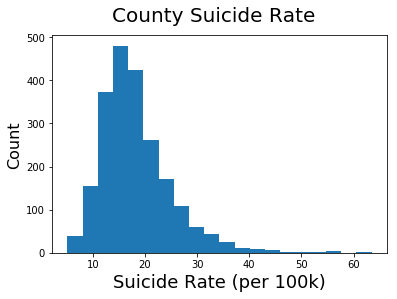

In [14]:
n_bins = 20
fig = plt.figure()
plt.hist(df_clean['Suicide Rate'], bins=n_bins)
fig.suptitle('County Suicide Rate', fontsize=20)
plt.xlabel('Suicide Rate (per 100k)', fontsize=18)
plt.ylabel('Count', fontsize=16)

Slope = -0.00014311174501675715
r-squared = 0.0769402436637569
p-value = 1.0656145376096341e-39


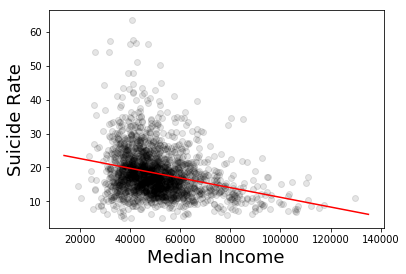

In [15]:
# Plot single variable (Median Income) against suicide rate

# Define x and y
x = df_clean['Median Income']
y = df_clean['Suicide Rate']

# Plot
fig = plt.scatter(x, y, c='black', alpha=0.1)
axes = plt.gca()
plt.ylabel('Suicide Rate', fontsize=18)
plt.xlabel('Median Income', fontsize=18)


# Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
# Plot a line from slope and intercept
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '-', color="red")
print(f"Slope = {slope}")
print(f"r-squared = {r_value**2}")
print(f"p-value = {p_value}")
# plt.savefig("happySauce_fig01.png")

Median Income
Slope = -0.00014311174501675715
r-squared = 0.0769402436637569
p-value = 1.0656145376096341e-39


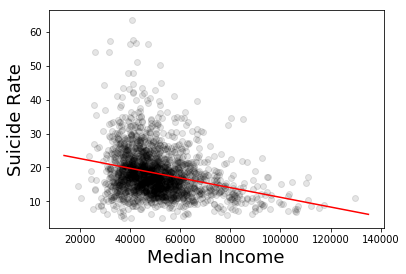

Log Population Density
Slope = -6.337024848584519
r-squared = 0.33589063076968434
p-value = 2.6435081806944163e-195


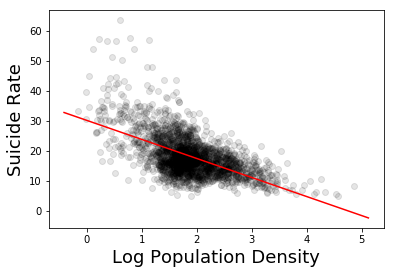

HS Drop Out Rate
Slope = 33.94808960735292
r-squared = 0.08913293944037541
p-value = 5.303344589221386e-46


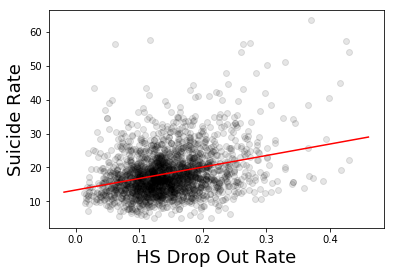

Unemployment Rate
Slope = 42.16373749400902
r-squared = 0.029698255633693025
p-value = 5.91009425140313e-16


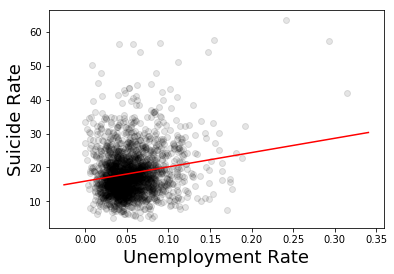

Uninsured Rate
Slope = 17.322260104546622
r-squared = 0.03685838338216437
p-value = 1.7085262409533072e-19


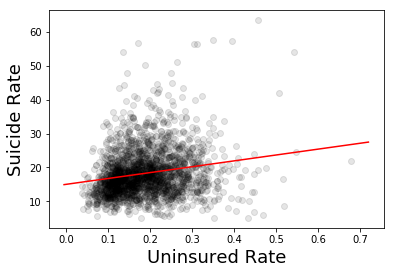

Poverty Rate
Slope = 13.277879849898094
r-squared = 0.012911630467275684
p-value = 1.0826916610072877e-07


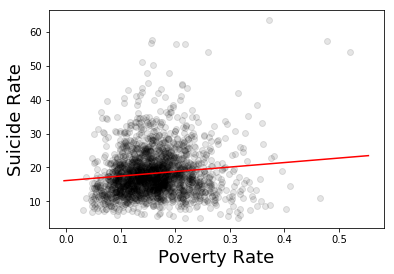

Veteran Rate
Slope = 51.88575372590652
r-squared = 0.13085044428969647
p-value = 3.3915341776379005e-68


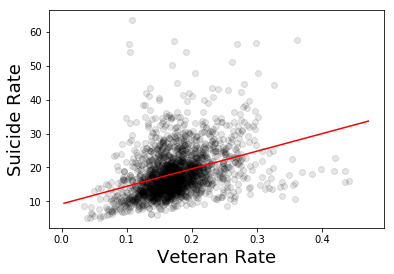

Disability Rate
Slope = 36.709584913452375
r-squared = 0.10223435690940752
p-value = 7.276498326824207e-53


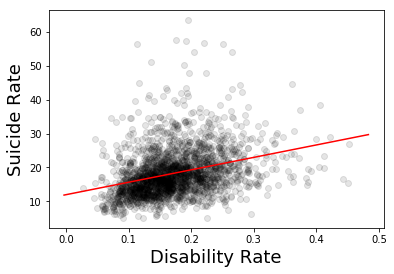

Housing Renter Rate
Slope = -19.62737749198066
r-squared = 0.04898795603959598
p-value = 1.5654340781085666e-25


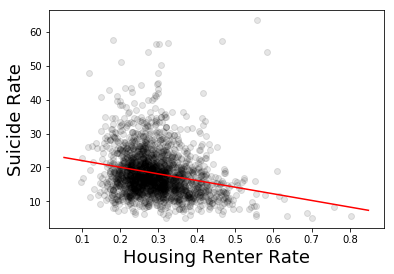

Living Alone Rate
Slope = 47.884572331474565
r-squared = 0.03559766114560081
p-value = 7.193846651541896e-19


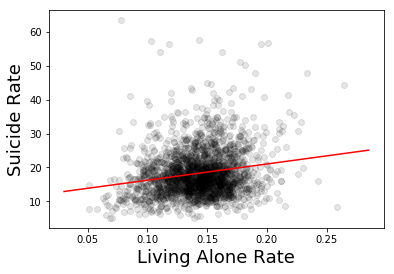

Professional Rate
Slope = -49.78461171118263
r-squared = 0.10644696875520847
p-value = 4.3143313002307265e-55


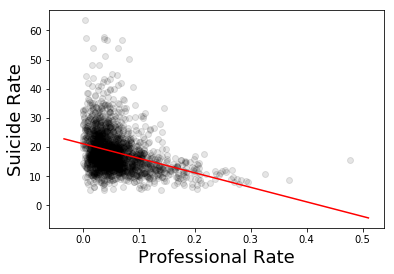

Native American Rate
Slope = 32.09948290119813
r-squared = 0.08774496080580786
p-value = 2.7929730196041318e-45


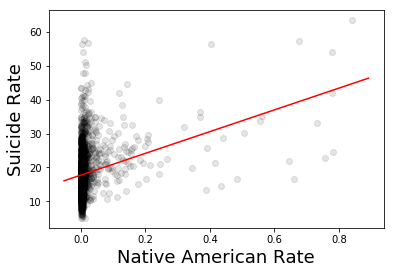

Daylight
Slope = 0.00040111824775073264
r-squared = 0.007602013899569364
p-value = 4.686606087344364e-05


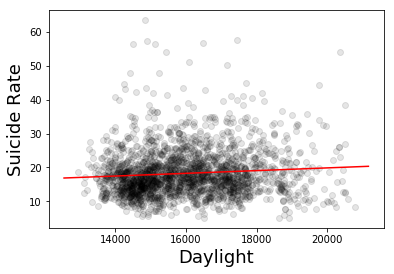

People per Mental Health Provider
Slope = 3.572316346031114e-05
r-squared = 0.004022718747026227
p-value = 0.0030910132768205726


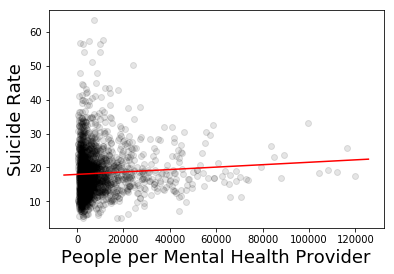

In [16]:
# Plot all variables against suicide rate

# List of all variables that will be in the multiple regression model
vars_model = ['Median Income', 'Log Population Density', 'HS Drop Out Rate', 'Unemployment Rate', 'Uninsured Rate', 'Poverty Rate', \
             'Veteran Rate', 'Disability Rate', 'Housing Renter Rate', 'Living Alone Rate', 'Professional Rate', 'Native American Rate', \
              'Daylight', 'People per Mental Health Provider']

# Plot all graphs
plt.figure()
for thisVar in vars_model:
    # Define x and y
    x = df_clean[thisVar]
    y = df_clean['Suicide Rate']
    # Plot data points
    plt.scatter(x, y, c='black', alpha=0.1)
    plt.ylabel('Suicide Rate', fontsize=18)
    plt.xlabel(thisVar, fontsize=18)
    # Linear Regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    # Plot a line from slope and intercept
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', color="red")
    print(thisVar)
    print(f"Slope = {slope}")
    print(f"r-squared = {r_value**2}")
    print(f"p-value = {p_value}")
    plt.show()


In [17]:
# Define variables for multiple regression model
X = df_clean[[*vars_model]]
y = df_clean['Suicide Rate'].values.reshape(-1, 1)
# print(X.shape, y.shape)
# Split data into train and test
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state =1) # 70% data for train, 30% for test
print(f'Train data: {len(y_train)} data points')
print(f'Test data: {len(y_test)} data points')


# Scale the data so the mean is 0 and the standard deviation is 1
# This will allow us to directly compare beta coefficients in the full model
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

Train data: 1521 data points
Test data: 653 data points


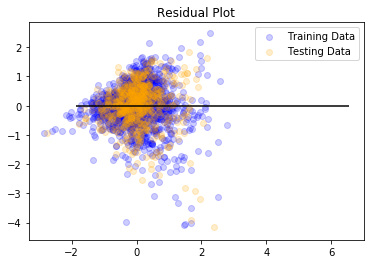

In [32]:
# Fit model and plot the residuals
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data", alpha=0.2)
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data", alpha=0.2)
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()

In [19]:
# Evaluate multiple regression model using test data set
predictions = model.predict(X_test_scaled)
MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)
print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.5564470479633032, R2: 0.4146699235493413


In [20]:
# Create dataframe with multiple regression beta coefficients and p-values
data = {'Variable': vars_model, 'Beta Coefficient': model.coef_.tolist()[0], 'p-value': model.p.tolist()[0]}
df_lm = pd.DataFrame(data)
alpha = 1-(1-0.05)**(1/len(vars_model)) # corrected for multiple comparisons (Sidak)
df_lm['Significant'] = df_lm['p-value'] < alpha

df_lm = df_lm.sort_values('Beta Coefficient', ascending =False)
df_lm

,Variable,Beta Coefficient,p-value,Significant
6,Veteran Rate,0.194334,0.000000e+00,True
7,Disability Rate,0.156141,2.989257e-07,True
11,Native American Rate,0.155283,1.165312e-11,True
9,Living Alone Rate,0.127878,4.826986e-07,True
2,HS Drop Out Rate,0.092850,5.922299e-05,True
12,Daylight,0.065842,7.262062e-03,False
10,Professional Rate,0.038880,2.080702e-01,False
0,Median Income,0.030894,5.240307e-01,False
4,Uninsured Rate,0.026007,3.550207e-01,False
3,Unemployment Rate,0.024952,3.123643e-01,False


In [201]:
# Create a neural network with multiple layers

# add r squared as a metric for model
def det_coeff(y_true, y_pred):
    u = K.sum(K.square(y_true - y_pred))
    v = K.sum(K.square(y_true - K.mean(y_true)))
    return K.ones_like(v) - (u / v)

# define model architecture
def build_model():
    deep_model = Sequential()
    deep_model.add(Dense(units=26, activation='sigmoid', input_dim=len(vars_model))) # try sigmoid vs. relu
    deep_model.add(Dense(units=10, activation='sigmoid'))
    deep_model.add(Dense(1))
    
    optimizer = tensorflow.keras.optimizers.RMSprop(0.001)
    deep_model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse', det_coeff])
    
    return deep_model

In [202]:
# build model and print summary
deep_model = build_model()
deep_model.summary()

# example_batch = X_train_scaled[:10]
# example_result = deep_model.predict(example_batch)
# example_result

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_109 (Dense)            (None, 26)                390       
_________________________________________________________________
dense_110 (Dense)            (None, 10)                270       
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 11        
Total params: 671
Trainable params: 671
Non-trainable params: 0
_________________________________________________________________


In [203]:
from tensorflow import keras
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

history = deep_model.fit(X_train_scaled, y_train_scaled, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])



....................................................................................................
...........................................................

In [204]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,det_coeff,val_loss,val_mean_absolute_error,val_mean_squared_error,val_det_coeff,epoch
154,0.415465,0.477880,0.415465,0.563380,0.492956,0.522424,0.492956,0.382427,154
155,0.414180,0.478549,0.414180,0.555769,0.494965,0.521506,0.494965,0.372077,155
156,0.414049,0.476651,0.414049,0.551283,0.494569,0.522440,0.494569,0.430915,156
157,0.413746,0.478847,0.413746,0.557454,0.497082,0.522808,0.497082,0.355421,157
158,0.413328,0.477450,0.413328,0.564411,0.494755,0.522711,0.494755,0.308607,158


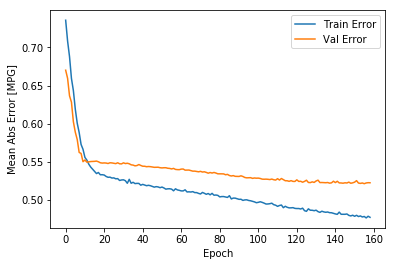

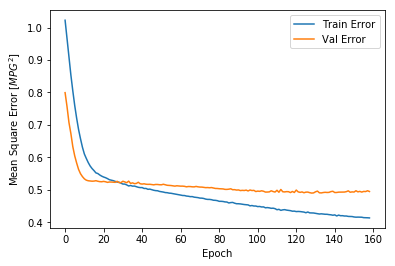

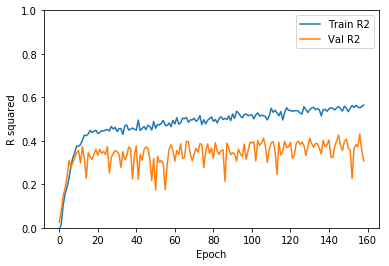

In [205]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
#   plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
#   plt.ylim([0,20])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('R squared')
  plt.plot(hist['epoch'], hist['det_coeff'],
           label='Train R2')
  plt.plot(hist['epoch'], hist['val_det_coeff'],
           label = 'Val R2')
  plt.ylim([0,1])
  plt.legend()

  plt.show()


plot_history(history)


In [206]:
# loss, mae, mse, r2 = deep_model.evaluate(X_test_scaled, y_test_scaled, verbose=2)

In [ ]:
# Compile the model
deep_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
# Fit the model to the training data
deep_model.fit(X_train_scaled, y_train_categorical, epochs=100, shuffle=True, verbose=2)

In [ ]:
model_loss, model_accuracy = deep_model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(f"Deep Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")